# Get Data from Wikipedia

I follow the tutorial at https://www.mediawiki.org/wiki/API:Tutorial. I decided to use the url for wikipedia since that way I have obtained more results (at least 200 different data records needed)

In [339]:
import pandas as pd

url = 'https://en.wikipedia.org/w/api.php'

In [340]:
params = {
    "action": "query",
    "list": "mostviewed", # get most viewed articles
    "pvimlimit": 20, # limit the result to 200
    "format" : "json"
}

In [341]:
import requests
r = requests.get(url, params=params)
print(r)

<Response [200]>


In [342]:
r.json()

{'batchcomplete': '',
 'continue': {'pvimoffset': 20, 'continue': '-||'},
 'query': {'mostviewed': [{'ns': 0, 'title': 'Main Page', 'count': 4530162},
   {'ns': -1, 'title': 'Special:Search', 'count': 1215598},
   {'ns': 0, 'title': 'Canadian Premier League', 'count': 660767},
   {'ns': 0, 'title': "ICC Men's T20 World Cup", 'count': 463637},
   {'ns': 0, 'title': 'Charles Cullen', 'count': 385911},
   {'ns': 0, 'title': 'Halloween', 'count': 373368},
   {'ns': 0, 'title': "2022 ICC Men's T20 World Cup", 'count': 331373},
   {'ns': 0, 'title': '2022 Brazilian general election', 'count': 261446},
   {'ns': 0, 'title': 'Jeffrey Dahmer', 'count': 253622},
   {'ns': 0, 'title': 'Jack Harlow', 'count': 202978},
   {'ns': 0, 'title': 'Jake Paul', 'count': 198289},
   {'ns': 0, 'title': 'Jake Paul vs. Anderson Silva', 'count': 197134},
   {'ns': 0, 'title': 'Cleopatra', 'count': 188548},
   {'ns': 4, 'title': 'Wikipedia:Featured pictures', 'count': 187146},
   {'ns': 0, 'title': 'YouTube', 'c

In [343]:
# Get titles:
article_titles = []
article_views = []
for idx, x in enumerate(r.json()['query']['mostviewed']):
    # I will not include the pages "Main Page" and "Special:Search".
    if (x['title'] != 'Main Page' and x['title'] != 'Special:Search'):
        article_titles.append(x['title'])
        article_views.append(x['count'])

In [344]:
import pandas as pd
df = pd.DataFrame(columns=['Title', 'Text', 'Views'])
df['Title'] = article_titles
df['Views'] = article_views
df.head()

,Title,Text,Views
0,Canadian Premier League,NaN,660767
1,ICC Men's T20 World Cup,NaN,463637
2,Charles Cullen,NaN,385911
3,Halloween,NaN,373368
4,2022 ICC Men's T20 World Cup,NaN,331373


In [345]:
# Create a scrapper:
from bs4 import BeautifulSoup
import re

def getWikiText(html_txt):
    soup = BeautifulSoup(html_txt, 'html.parser')
    # we are interested in those that are tagged as <p> which stands for paragraphs.
    text = ''
    for paragraph in soup.find_all('p'):
        text += paragraph.text
        # Let’s do a little bit of cleaning to get the exact output from the previous section
    text = re.sub(r'\[.*?\]+', '', text)
    text = text.replace('\n', '')
    return text


In [346]:
# Request the article for each page:

for idx, title in enumerate(df['Title']):
    params = {
        "action": "parse",
        "prop": "text",
        "page": title,
        "format" : "json"
    }
    try:
        request = requests.get(url, params=params)
        if request.status_code != 200:
            raise Exception(f"Download failed with code {request.status_code}")
        else:
            df.at[idx, 'Text']= getWikiText(request.json()['parse']['text']['*'])
    except Exception as e:
        print(e)

In [347]:
df.head()

,Title,Text,Views
0,Canadian Premier League,The Canadian Premier League (CPL or CanPL; Fre...,660767
1,ICC Men's T20 World Cup,The ICC Men's T20 World Cup (earlier known as ...,463637
2,Charles Cullen,"Charles Edmund Cullen (born February 22, 1960)...",385911
3,Halloween,Halloween or Hallowe'en (less commonly known a...,373368
4,2022 ICC Men's T20 World Cup,The 2022 ICC Men's T20 World Cup is the eighth...,331373


# Create a Word Cloud

Source: https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5

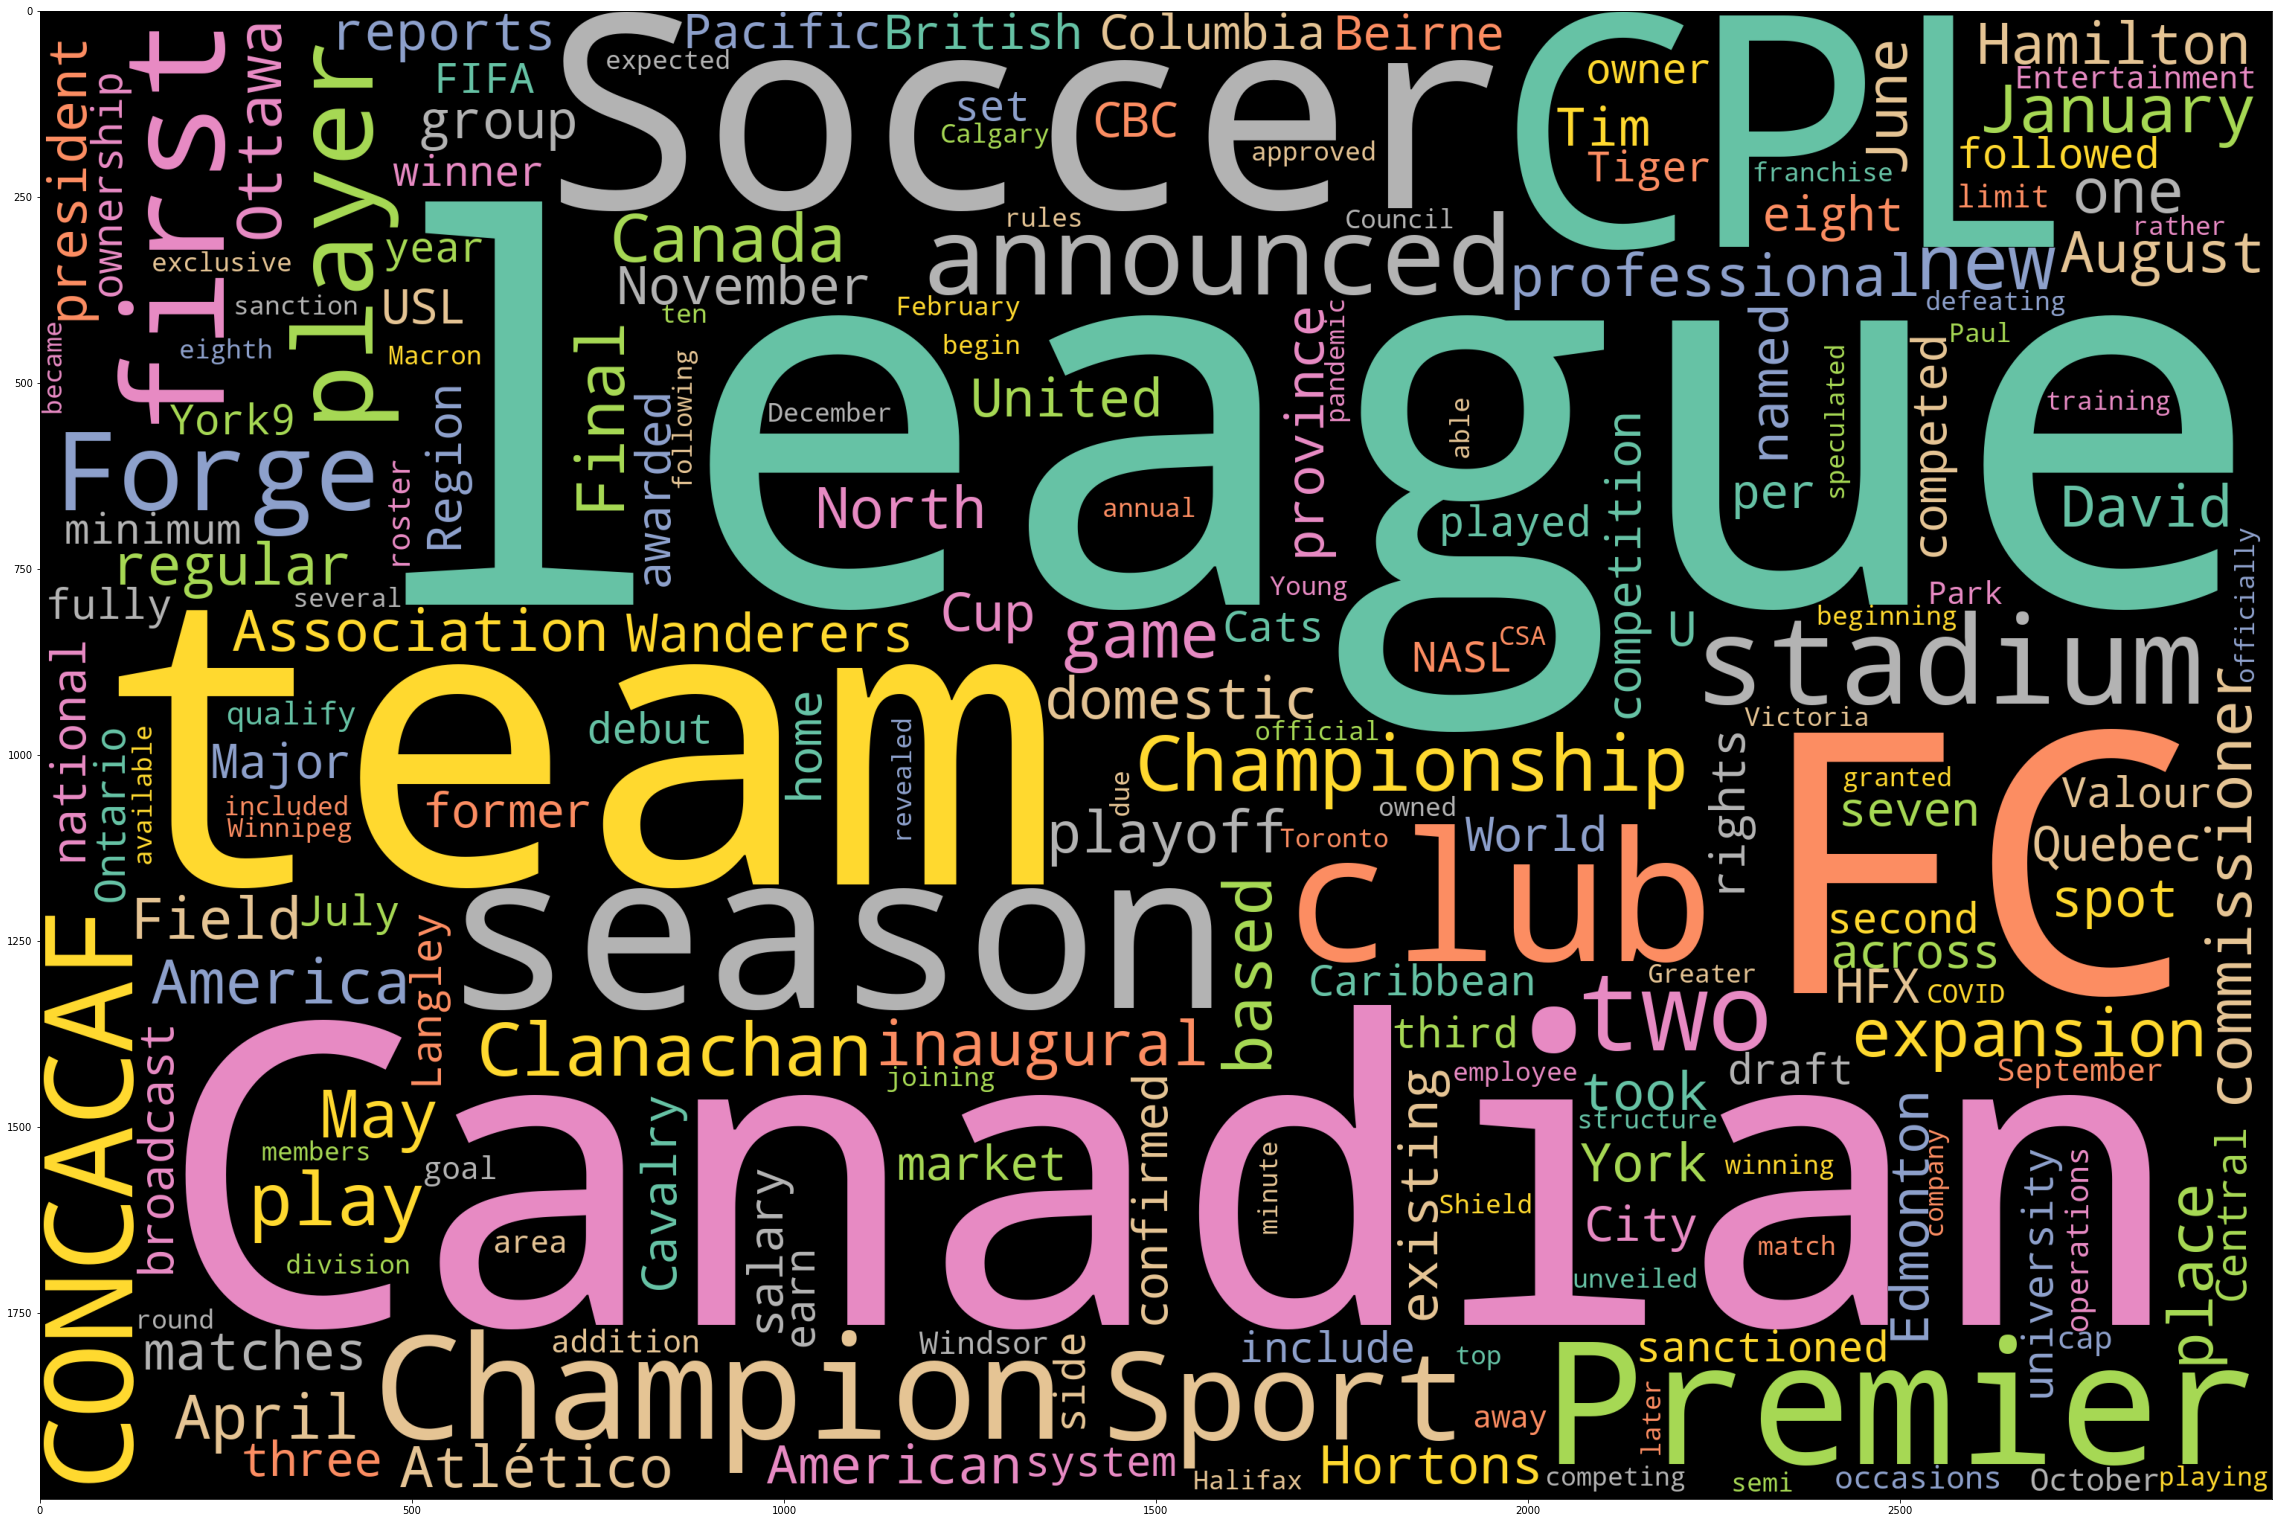

In [350]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Generate word cloud
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(df['Text'][0])

plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)